# Imports & Constants

In [111]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
import numpy as np
import shutil
import time
import json
from datetime import datetime



def extract_time_format_from_datetime(formatted_time):
    if("T" in formatted_time):
      formatted_time = formatted_time.split("+")[0]
      formatted_time = formatted_time.replace("T", " ")
      return "%Y-%m-%dT%H:%M:%S"
    return "%Y-%m-%d %H:%M:%S.%f"
def convert_datetime_to_time_since_last_epoch(formatted_time):
    time_format = extract_time_format_from_datetime(formatted_time)
    time_struct = time.strptime(formatted_time, time_format)
    datetime_obj = datetime.fromtimestamp(time.mktime(time_struct))
    return datetime_obj.timestamp()

# Most recent directory
galaxy_watch_folder_dir = "./data/galaxywatch/"+os.listdir("./data/galaxywatch/")[-1] + "/"
exercise_logs_folder_dir = "./data/exerciselogs/"
computer_usage_folder_dir = "./data/computerusage/"

# First day of college 
# data_start_time = convert_datetime_to_time_since_last_epoch("2023-8-16 00:00:00.0")

# 3 weeks out
data_start_time = round(convert_datetime_to_time_since_last_epoch("2023-8-15 00:00:00.0"))
data_end_time = round(convert_datetime_to_time_since_last_epoch("2023-9-24 00:00:00.0"))
data_end_time, data_start_time


(1695531600, 1692075600)

# Data Management

In [6]:
# Check to see if there is any new data (from my android phone)
# Define the source and destination directories
src_dir = "/run/user/1000/gvfs/mtp:host=motorola_motorola_one_5G_ace_ZY22DDHW4G/Internal shared storage/Download/Samsung Health"
dest_dir = "./data"

# Loop through all the directories in the source directory
for dir_name in os.listdir(src_dir):
    # Check if the item is a directory
    if os.path.isdir(os.path.join(src_dir, dir_name)):
        # Check if the directory already exists in the destination directory
        if not os.path.exists(os.path.join(dest_dir, dir_name)):
            # If it doesn't exist, copy it over
            shutil.copytree(os.path.join(src_dir, dir_name), os.path.join(dest_dir, dir_name))

In [7]:
# Clean up the data a but
dest_dir = "./data/galaxywatch/"
for dir_name in os.listdir(dest_dir):
    folder_dir = f"./data/{dir_name}/"

    # Do some cleaning on the folder data
    date_time_of_upload = folder_dir.split("_")[-1][:-1]

    # Rename all of the files so that they are easier to deal with
    for file_name in os.listdir(folder_dir):
        if os.path.isdir(folder_dir + file_name):
            continue
        if "com.samsung" not in file_name:
            continue
        new_file_name = file_name.replace(".".join(file_name.split(
            ".")[:3]) + ".", "").replace(date_time_of_upload + ".", "")
        os.rename(folder_dir + file_name, folder_dir + new_file_name)

    # Clean csv's so that they dont have that first line with junk
    for file_name in os.listdir(folder_dir):
        if os.path.isdir(folder_dir + file_name):
            continue
        file_text = ""
        with open(folder_dir + file_name, "r") as f:
            file_text = f.read()

            if "com.samsung" in (file_text.split("\n")[0]):
                file_text = "\n".join(file_text.split("\n")[1:])
                with open(folder_dir + file_name, "w") as f:
                    f.write(file_text)


# Helper functions

In [131]:

def average_series(series_1, series_2):
    new_series = pd.Series(dtype=pd.Float64Dtype)
    for column in series_1.index:
        if type(series_1[column]) == str:
            continue
        new_series[column] = (series_1[column] + series_2[column]) / 2
    return new_series

# Define a function to find the closest weight entry in fitdays_data for a given row in shealth_data
def average_measurements_that_are_close_in_time(dataframe: pd.DataFrame, time_column_name, group_1_function, group_2_function, time_difference_threshold, mode = "mean"):
    # Calculate the time difference between the current row and all rows in fitdays_data

    group_1_dataframe = group_1_function(dataframe)
    group_2_dataframe = group_2_function(dataframe)

    group_1_dataframe = group_1_dataframe.sort_values(by=time_column_name)
    group_2_dataframe = group_2_dataframe.sort_values(by=time_column_name)

    new_dataframe = pd.DataFrame(columns=group_1_dataframe.columns)

    # for each entry in the group_1_dataframe, find the neastest entry in time
    for (index, row) in group_1_dataframe.iterrows():
        candidates = (group_2_dataframe[abs(group_2_dataframe[time_column_name] - row[time_column_name]) < time_difference_threshold])
        if candidates.shape[0] == 0:
            continue
        
        match mode:
            case "mean":
                another_row = average_series(candidates.iloc[0], row)
                new_dataframe = pd.concat([new_dataframe, another_row.to_frame().T], ignore_index=True)

    return new_dataframe

def plot_variables(df, x_axis_column_name, y_axis_column_names, y_axis_visible, title, image_name = "plot.png"):

  assert len(y_axis_column_names) >= 2

  if(image_name == "plot.png"):
    image_name = image_name.replace(".png", "_for_") + to_snake_case(title)+ ".png"

  color_hex_codes = ['#FF5733', '#40E0D0', '#4169E1', '#32CD32', '#FFD700', '#DA70D6', '#FF7F50', '#708090', '#FF1493', '#008B8B']

  axes = []
  fig, ax1 = plt.subplots(figsize=(16, 9))
  ax2 = ax1.twinx()

  axes = [ax1, ax2]

  if len(y_axis_column_names) > 2:
    for i in range(2, len(y_axis_column_names)):
      axes.append(axes[i % 2].twinx())
  else:
    # Label the axes with the two different column names
    axes[0].set_ylabel(convert_snake_case_to_pascal_case(y_axis_column_names[0]))
    axes[1].set_ylabel(convert_snake_case_to_pascal_case(y_axis_column_names[1]))
  
  for ax, column_name in zip(axes, y_axis_column_names):
    random.seed(69)
    color = random.choice(color_hex_codes)
    color_hex_codes.remove(color)
    print(column_name, " is ", color)
    ax.plot(df[x_axis_column_name], df[column_name], label=column_name, color=color)

    ax.get_yaxis().set_visible(y_axis_visible)
    plt.legend()
  
  if "date" == x_axis_column_name:
    convert_time_since_last_epoch_x_axis_to_date(ax)
  plt.title(title)
  plt.savefig(f"./figs/{image_name}")
  plt.show()

def convert_time_since_last_epoch_to_date(time_since_last_epoch):
    time_struct = time.localtime(time_since_last_epoch)
    datetime_obj = datetime.fromtimestamp(time.mktime(time_struct))
    return datetime_obj.strftime("%Y/%m/%d")

def convert_snake_case_to_pascal_case(snake_case_string):
    return "".join([word.capitalize() for word in snake_case_string.split("_")])

def extract_time_format_from_datetime(formatted_time:str):
    if formatted_time.count(":") < 1:
      return "%Y-%m-%d"
    elif "T" in formatted_time:
      formatted_time = formatted_time.split("+")[0]
      formatted_time = formatted_time.replace("T", " ")
      return "%Y-%m-%dT%H:%M:%S"
    return "%Y-%m-%d %H:%M:%S.%f"
def convert_datetime_to_time_since_last_epoch(formatted_time):
    formatted_time = formatted_time.replace("/", "-")
    time_format = extract_time_format_from_datetime(formatted_time)
    time_struct = time.strptime(formatted_time, time_format)
    datetime_obj = datetime.fromtimestamp(time.mktime(time_struct))
    return datetime_obj.timestamp()
def apply_conversion_to_muliple_columns(dataframe, column_names, conversion: float):
    if type(conversion) == list:
        raise Exception("muliptle conversions not implemented yet")

    for column in column_names:
        dataframe[column] = dataframe[column].apply(lambda x: float(x) * conversion)
    return dataframe

def convert_time_since_last_epoch_x_axis_to_date(ax):
  labels = ax.get_xticklabels()
  # Define the new x-axis tick labels
  new_labels = [convert_time_since_last_epoch_to_date(float(label.get_text()) * 1e9) for label in labels]
  
  # Set the new x-axis tick labels
  ax.set_xticklabels(new_labels)

def convert_utc_offset_to_hours(utc_offset):
  example = "UTC-05:00"
  return int(utc_offset.split("-")[1][:2])

def remove_columns(dataframe, columns):
  return dataframe.drop(columns=columns)

weekday_int_to_day = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
def convert_datetime_to_weekday(dataframe, column_name, weekday_int_to_day = False):
  if(weekday_int_to_day):
    dataframe["day_of_the_week"] = dataframe[column_name].apply(lambda x: weekday_int_to_day[datetime.fromtimestamp(x).weekday()])
  else:
    dataframe["day_of_the_week"] = dataframe[column_name].apply(lambda x: datetime.fromtimestamp(x).weekday())
  return dataframe

def to_snake_case(string):
  return "_".join(string.split(" ")).lower()

def clamp_dataframe_time(dataframe, time_name, start_time, end_time):
  return dataframe[(dataframe[time_name] >= start_time) & (dataframe[time_name] <= end_time)]

def plot_box_and_whisker(dataframe: pd.DataFrame, x_axis_column_name, y_axis_column_name, title, x_axis_label, y_axis_label, image_name="box_and_whisker.png"):
  if(image_name == "box_and_whisker.png"):
    image_name = image_name.replace(".png", "_for_") + to_snake_case(title) + ".png" 
  axes = dataframe.boxplot(column=y_axis_column_name, by=x_axis_column_name, return_type='axes', figsize=(16, 9))
  axes = (axes[y_axis_column_name])
  
  axes.set_xlabel(x_axis_label)
  axes.set_ylabel(y_axis_label)
  axes.set_title(title)

  # Get the current x-axis tick labels
  # labels = axes.get_xticklabels()
  if x_axis_column_name == "day_of_the_week":
    new_labels = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    
    # Set the new x-axis tick labels
    axes.set_xticklabels(new_labels)

  plt.savefig(f"./figs/{image_name}")
  plt.show()


def plot_scatter(dataframe, x_axis_column_name, y_axis_column_name):
  dataframe.plot.scatter(x=x_axis_column_name, y=y_axis_column_name)
  plt.show()

# Plot the line of best fit for the data
def plot_line_of_best_fit(dataframe, x_axis_column_name, y_axis_column_name, title, x_axis_label, y_axis_label, image_name = "line_of_best_fit.png"):
  if(image_name == "line_of_best_fit.png"):
    image_name = image_name.replace(".png", "_for_") + to_snake_case(title) + ".png" 
  x = dataframe[x_axis_column_name]
  y = dataframe[y_axis_column_name]
  m, b = np.polyfit(x, y, 1)
  fig, ax = plt.subplots(figsize=(16, 9))
  ax.set_title(title)
  ax.set_xlabel(x_axis_label)
  ax.set_ylabel(y_axis_label)
  ax.plot(x, y, '.', label="data")
  ax.plot(x, m*x + b, '-', label="line of best fit")
  if "date" not in x_axis_column_name:
    convert_time_since_last_epoch_x_axis_to_date(ax)
  ax.legend()
  plt.savefig(f"./figs/{image_name}")
  plt.show()


def do_the_rudamentary_time_changes(dataframe: pd.DataFrame):
    columns_to_convert_to_time_since_last_epoch = ["start_time", "end_time"]
    print(dataframe.columns)
    if "time_offset" in dataframe.columns:
      dataframe["time_offset"] = convert_utc_offset_to_hours(dataframe["time_offset"].iloc[0])
    else:
      dataframe["time_offset"] = 0
    for column in columns_to_convert_to_time_since_last_epoch:
        if column in dataframe.columns and type(dataframe[column].iloc[0]) == str:
          dataframe[column] = dataframe[column].apply(convert_datetime_to_time_since_last_epoch) - dataframe["time_offset"] * 3600

    dataframe = dataframe.sort_values(by="start_time")
    if "end_time" in dataframe.columns:
      dataframe = convert_datetime_to_weekday(dataframe=dataframe, column_name="end_time")
    elif "start_time" in dataframe.columns:
      dataframe = convert_datetime_to_weekday(dataframe=dataframe, column_name="start_time")
      
    dataframe = clamp_dataframe_time(dataframe, "start_time", data_start_time, data_end_time)
    dataframe["date"] = dataframe["start_time"].apply(convert_time_since_last_epoch_to_date)
    return dataframe

def sum_df_by_variable(df: pd.DataFrame, x_axis, y_axies, modes):
    # Group computer usage events by date
    grouped = df.groupby(df[x_axis])

    if type(y_axies) == str:
        y_axies = [y_axies]

    if type(modes) == str:
        modes = [modes]
    if len(y_axies) > len(modes) and len(modes) == 1:
        modes = modes * len(y_axies)
    elif len(y_axies) < len(modes) and len(y_axies) == 1:
        y_axies = y_axies * len(modes)
    elif len(y_axies) != len(modes):
        raise Exception("y_axies and modes must be the same length")

    # Create new DataFrame with the total durations
    result_df = pd.DataFrame({
        # x_axis: grouped.groups,
    })
    for axis, mode in zip(y_axies, modes):
        match mode:
            case "mean":
                result_df[axis] = grouped[axis].mean()
            case "sum":
                result_df[axis] = grouped[axis].sum()
            case "max":
                result_df[axis] = grouped[axis].max()
            case "min":
                result_df[axis] = grouped[axis].min()
            case "first":
                result_df[axis] = grouped[axis].first()
            case _:
                raise Exception("Invalid mode")
    # if ""
    #     "last_time_used" : grouped["start_time"].max()
    # result_df["start_of_the_day"] = result_df["date"].apply(lambda x: str(x) + " 00:00:00.00").apply(convert_datetime_to_time_since_last_epoch)
    # result_df["last_time_used"] = (result_df["last_time_used"] - result_df["start_of_the_day"])  / 3600
    return result_df


remove_prefix = lambda x: x.replace("com.samsung.health.sleep.", "")


# Weight

In [6]:
weight = pd.read_csv(galaxy_watch_folder_dir + "weight.csv", index_col=False)
# filter weight

# weight = weight[weight["pkg_name"].isin(["cn.fitdays.fitdays"])]
weight = weight[pd.notna(weight["body_fat_mass"])]
weight["start_time"] = weight["start_time"].apply(convert_datetime_to_time_since_last_epoch)
weight = weight.rename(columns = {"total_body_water" : "water_mass"})
weight = apply_conversion_to_muliple_columns(weight, ["body_fat_mass", "weight", "muscle_mass", "skeletal_muscle_mass", "fat_free_mass", "water_mass"], 2.2)
weight = clamp_dataframe_time(weight, "start_time", data_start_time, data_end_time)

weight["time_offset"] = convert_utc_offset_to_hours(weight["time_offset"].iloc[0])
weight["start_time"] = weight["start_time"] - weight["time_offset"] * 60 * 60

# For every weight entry that has a package name of "com.sec.android.app.shealth" find the closest weight entry from cn.fitdays.fitdays, make sure they are less than 7200 seconds apart

print(weight["pkg_name"].unique())
group_1_function = lambda df: df[df["pkg_name"] == "com.sec.android.app.shealth"]
group_2_function = lambda df: df[df["pkg_name"] == "cn.fitdays.fitdays"]
    
weight = average_measurements_that_are_close_in_time(weight, "start_time", group_1_function, group_2_function, 3600 * 12)

weight = weight.sort_values(by="start_time")
weight.drop(['custom', 'comment', "datauuid", "vfa_level", "deviceuuid", ], axis=1, inplace=True)
weight.head(15)

['cn.fitdays.fitdays' 'com.sec.android.app.shealth']


,body_fat_mass,start_time,height,weight,muscle_mass,update_time,create_time,skeletal_muscle,fat_free_mass,basal_metabolic_rate,time_offset,skeletal_muscle_mass,fat_free,pkg_name,body_fat,water_mass
0,55.134726,1.693936e+09,181.94,204.375281,NaN,NaN,NaN,44.964622,103.663825,1928.0,5.0,91.896804,73.022818,NaN,26.977181,105.967769
1,52.515351,1.694004e+09,181.94,201.967799,NaN,NaN,NaN,45.613293,103.607534,1928.0,5.0,92.123823,73.998110,NaN,26.001893,106.040007
2,53.464714,1.694093e+09,181.94,202.597175,NaN,NaN,NaN,45.342107,103.340336,1925.0,5.0,91.862865,73.610447,NaN,26.389550,105.808137
3,55.055744,1.694183e+09,181.94,203.486228,NaN,NaN,NaN,44.886290,102.642987,1919.0,5.0,91.338093,72.943783,NaN,27.056221,105.343205
4,53.261866,1.694360e+09,181.94,200.399480,NaN,NaN,NaN,45.211075,101.041017,1903.0,5.0,90.603779,73.422200,NaN,26.577803,104.186740
5,55.050255,1.694447e+09,181.94,202.597175,NaN,NaN,NaN,44.816615,101.754796,1909.5,5.0,90.798356,72.827752,NaN,27.172245,104.630600
6,54.044257,1.694612e+09,181.94,202.177591,NaN,NaN,NaN,45.125572,102.238478,1914.5,5.0,91.233912,73.268925,NaN,26.731074,105.110520
7,55.542633,1.694788e+09,181.94,204.165500,NaN,NaN,NaN,44.776487,102.891030,1921.0,5.0,91.417869,72.795280,NaN,27.204722,105.382706
8,53.091088,1.694891e+09,181.94,203.646130,NaN,NaN,NaN,45.549498,104.718037,1939.5,5.0,92.762931,73.930252,NaN,26.069747,106.861612
9,55.117010,1.695045e+09,181.94,202.856856,NaN,NaN,NaN,44.820587,101.898003,1911.5,5.0,90.920778,72.829585,NaN,27.170416,104.713928


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


skeletal_muscle_mass  is  #FF5733
weight  is  #40E0D0
body_fat  is  #4169E1


/tmp/ipykernel_1001745/39580763.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels)


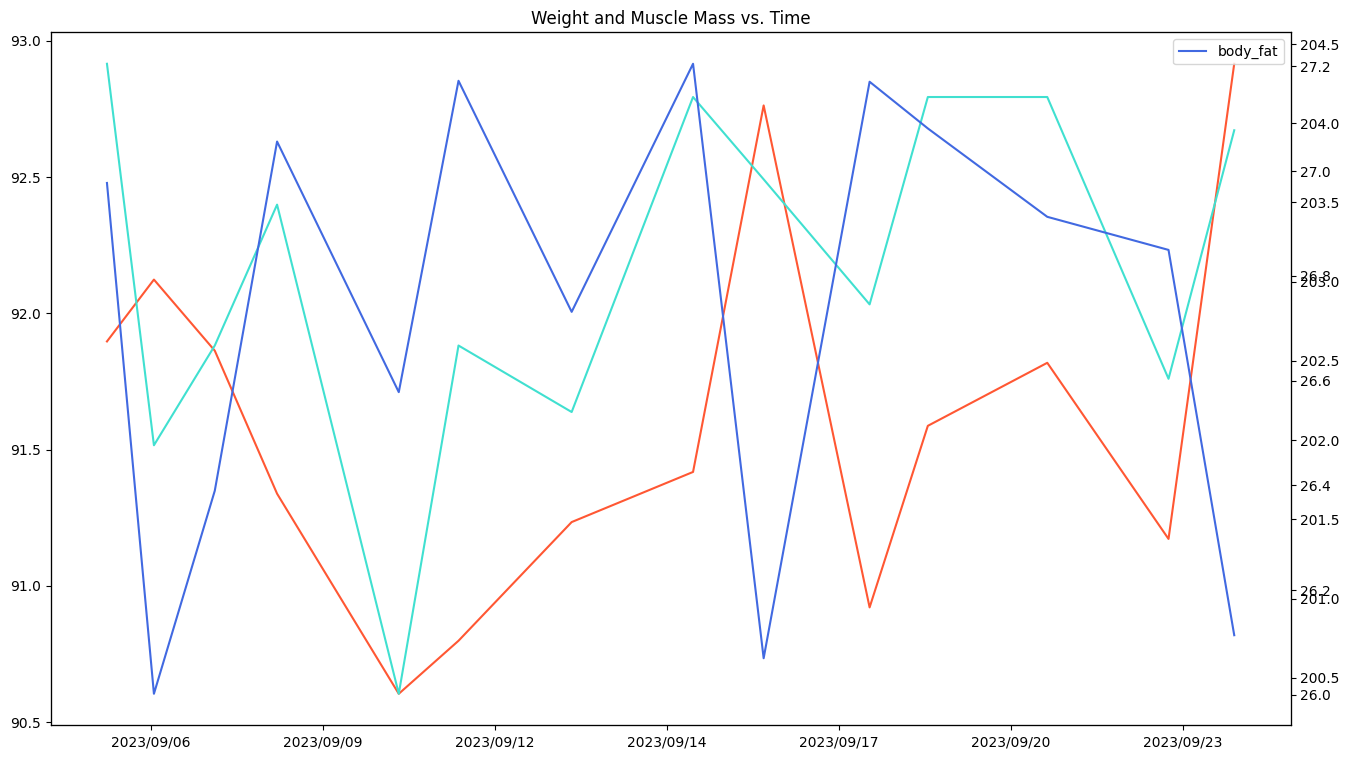

In [114]:

plot_variables(weight, "start_time", ["skeletal_muscle_mass", "weight", "body_fat"], True, title="Weight and Muscle Mass vs. Time")

In [ ]:
# get the value of a

## Sleep

In [104]:

sleep = pd.read_csv(galaxy_watch_folder_dir + "sleep.csv", index_col=False)

columns_to_remove = ["comment", "datauuid", "custom","deviceuuid","pkg_name", "original_efficiency", "extra_data", "quality", "original_bed_time", "create_time", "update_time", "combined_id", "has_sleep_data", "sleep_type", "data_version"]
# Remove columns from sleep

# Rename the columns using the lambda function
sleep = sleep.rename(columns=remove_prefix)
sleep = sleep.drop(columns=columns_to_remove)
sleep["sleep_duration"] = sleep["sleep_duration"].apply(lambda x: float(x) / 60)

# Change starttime so its local timzone
sleep = do_the_rudamentary_time_changes(sleep)


daily_sleep = sum_df_by_variable(sleep, "date", ["sleep_duration", "day_of_the_week", "start_time", "sleep_score"], ["sum", "first", "mean", "mean"])


Index(['mental_recovery', 'factor_01', 'factor_02', 'factor_03', 'factor_04',
       'factor_05', 'factor_06', 'factor_07', 'factor_08', 'factor_09',
       'factor_10', 'physical_recovery', 'original_wake_up_time',
       'movement_awakening', 'sleep_cycle', 'efficiency', 'sleep_score',
       'sleep_duration', 'start_time', 'time_offset', 'end_time'],
      dtype='object')


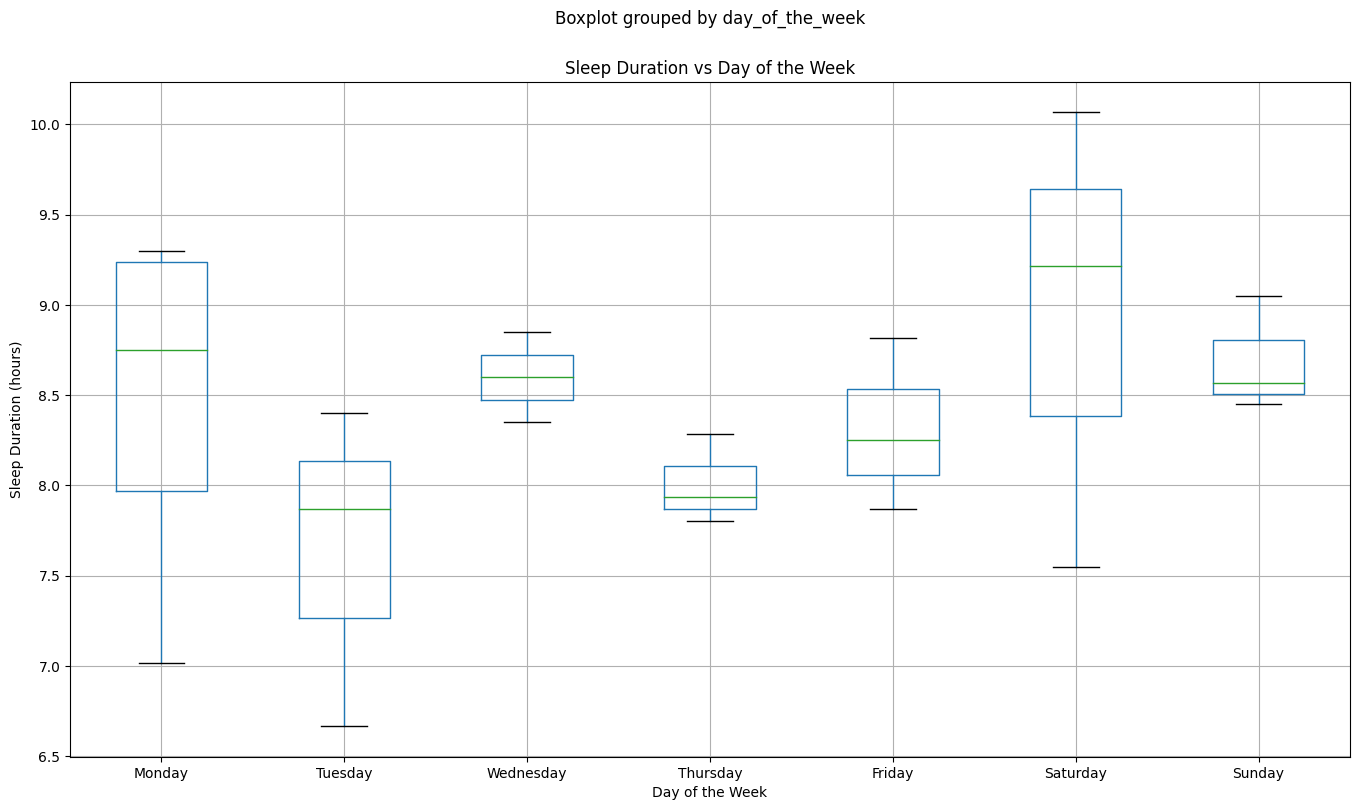

In [98]:
# Plot box and whisker chart for day of the week and amount slept

plot_box_and_whisker(daily_sleep, "day_of_the_week", "sleep_duration", "Sleep Duration vs Day of the Week", "Day of the Week", "Sleep Duration (hours)")

/tmp/ipykernel_825783/4133941835.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels)


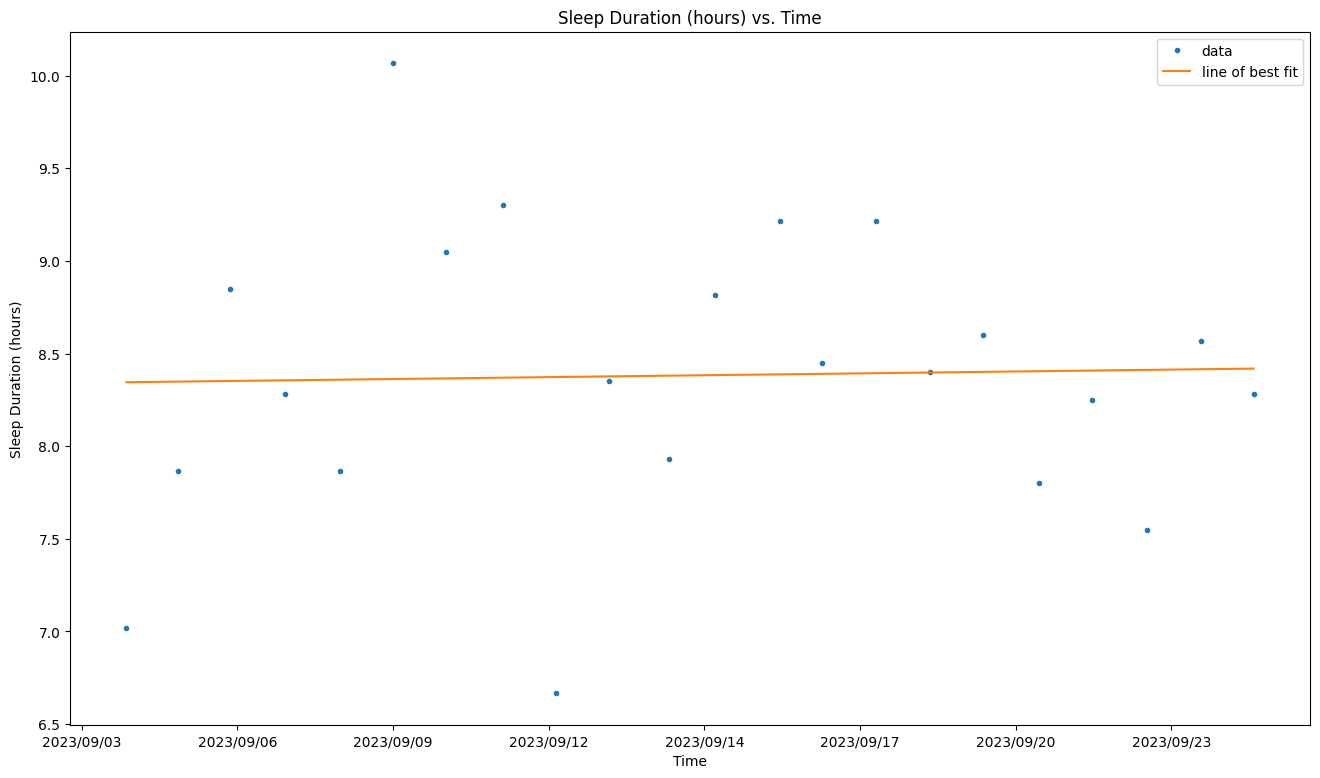

In [104]:
  
# plot_scatter(sleep, "com.samsung.health.sleep.start_time","sleep_duration")
plot_line_of_best_fit(daily_sleep, "start_time","sleep_duration", "Sleep Duration (hours) vs. Time", "Time", "Sleep Duration (hours)")

# Stress

In [109]:
stress = pd.read_csv(galaxy_watch_folder_dir + "stress.csv", index_col=False)
stress = stress.rename(columns=remove_prefix)
columns_to_remove = ["custom",	"binning_data",	"tag_id",	"create_time",	"algorithm",	"deviceuuid",	"comment",	"pkg_name",	"datauuid"]
stress = stress.drop(columns=columns_to_remove)

stress = do_the_rudamentary_time_changes(stress)
stress["hour"] = stress["start_time"].apply(lambda x: datetime.fromtimestamp(x).hour)
stress.head(10)
daily_stress = sum_df_by_variable(stress, "date", ["score", "max", "min", "score", "day_of_the_week"], ["mean"])
daily_stress

Index(['start_time', 'update_time', 'max', 'min', 'score', 'time_offset',
       'end_time'],
      dtype='object')


,score,max,min,day_of_the_week
date,,,,
2023/08/15,23.470588,73.470588,1.411765,1.0
2023/08/16,11.894737,50.315789,0.315789,2.0
2023/08/17,24.066667,76.333333,2.066667,3.0
2023/08/18,17.105263,56.421053,1.052632,4.0
2023/08/19,24.312500,83.312500,2.062500,5.0
2023/08/20,26.533333,62.600000,6.466667,6.0
2023/08/21,10.705882,54.411765,0.823529,0.0
2023/08/22,14.411765,61.588235,1.117647,1.0
2023/08/23,26.777778,80.222222,6.222222,2.0


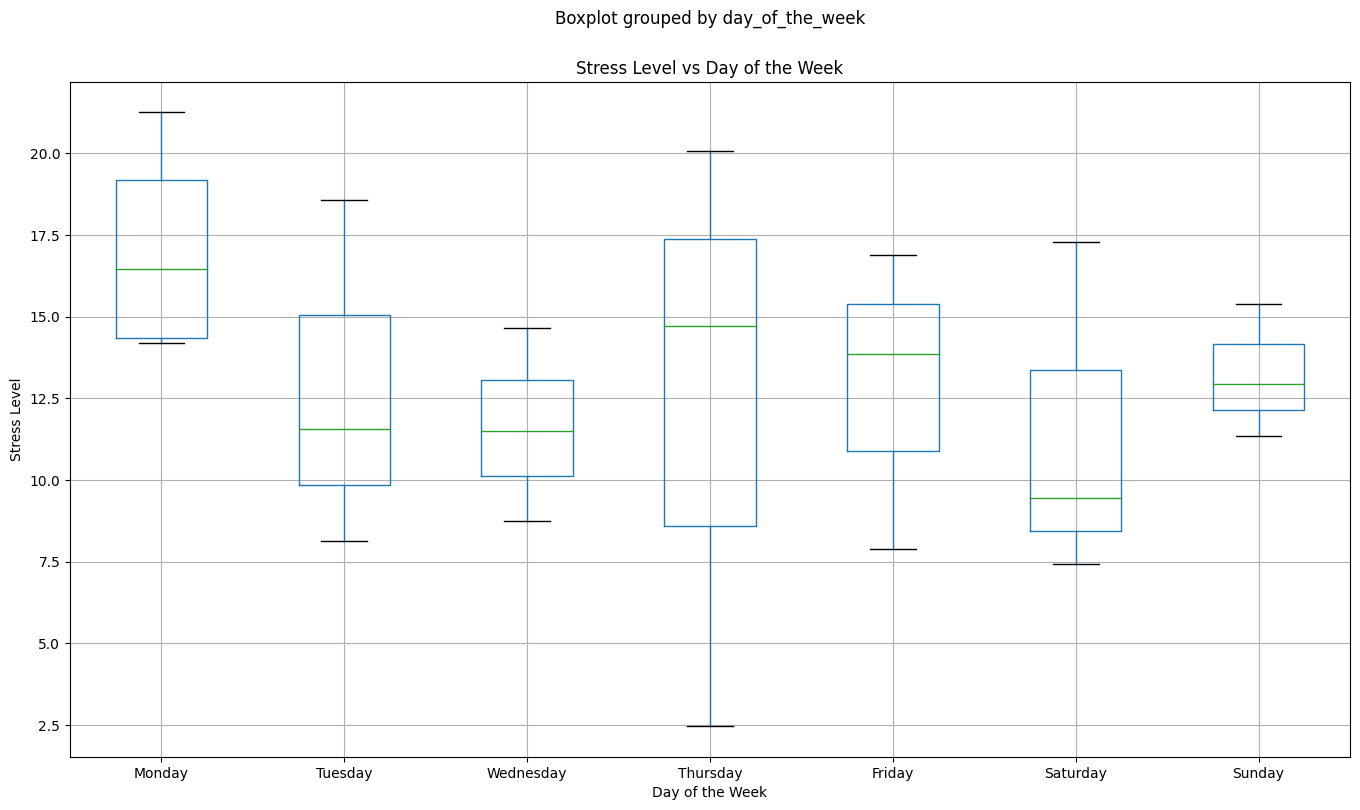

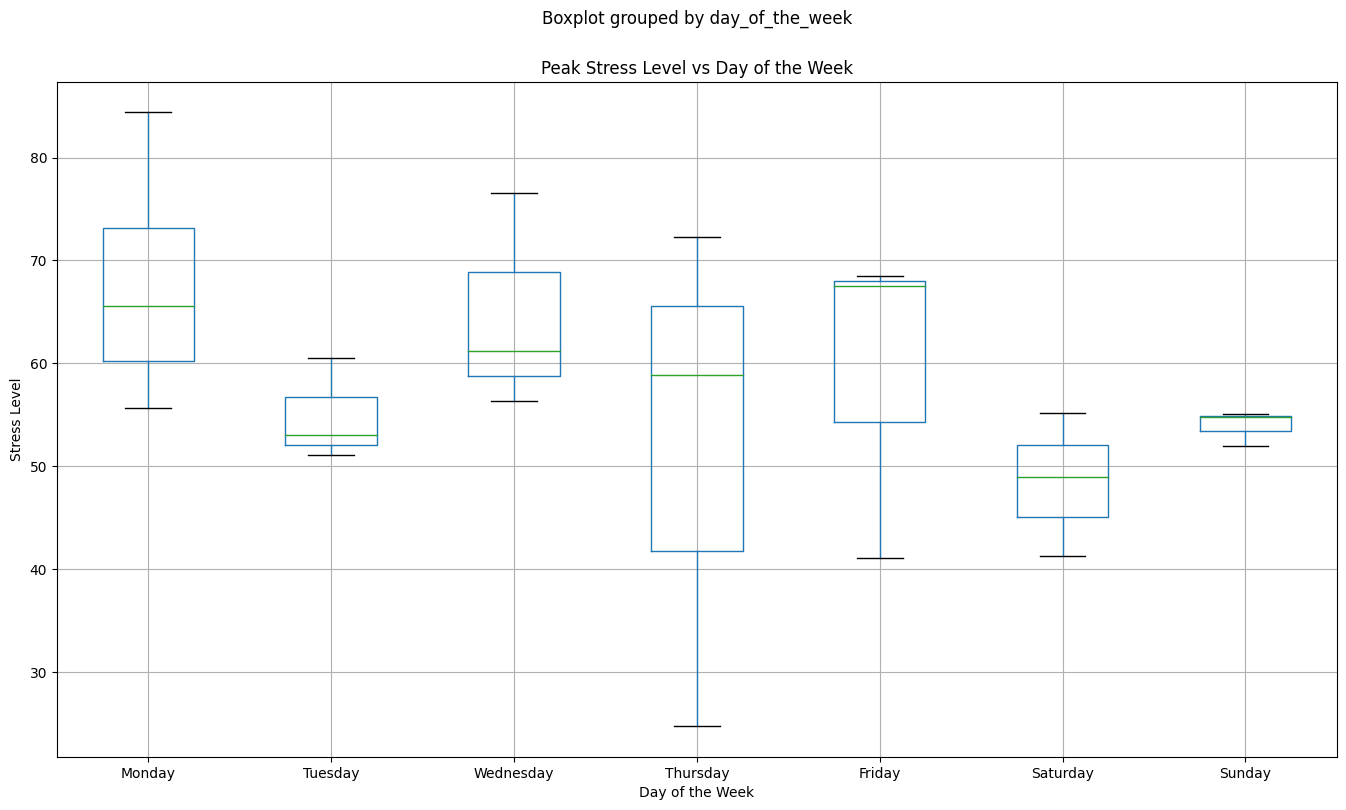

In [18]:
plot_box_and_whisker(daily_stress, "day_of_the_week", "score", "Stress Level vs Day of the Week", "Day of the Week", "Stress Level")
plot_box_and_whisker(daily_stress, "day_of_the_week", "max", "Peak Stress Level vs Day of the Week", "Day of the Week", "Stress Level")

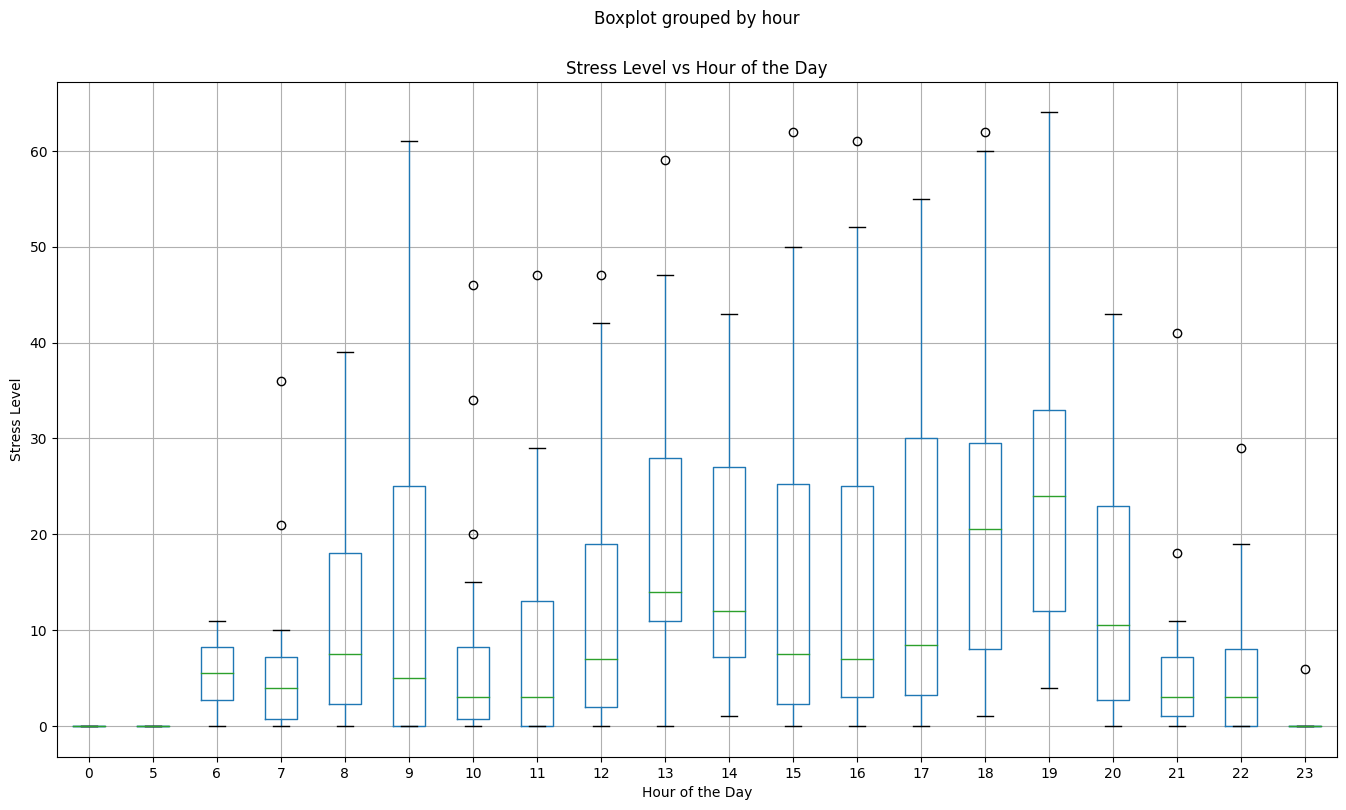

In [19]:
plot_box_and_whisker(stress, "hour", "score", "Stress Level vs Hour of the Day", "Hour of the Day", "Stress Level")

In [112]:
def plot_matrix(dataframe: pd.DataFrame, x_axies, y_axis, title):
  # This function will be used to see the average stress given a specific hour and given a specific day
  assert len(x_axies) == 2

  avg_stress = dataframe.groupby([x_axies[0], x_axies[1]])[y_axis].mean()

  # convert the resulting series to a matrix with days as rows and hours as columns
  matrix = avg_stress.unstack(level=1)
  
  plt.imshow(matrix, cmap="hot", interpolation="nearest")
  plt.colorbar()


plot_matrix(stress, ["day_of_the_week", "hour"], "score",  "Stress Correlation Matrix")

KeyError: 'hour'

# Computer Usage

In [22]:
data = json.loads(open(computer_usage_folder_dir + "aw-bucket-export_aw-watcher-window_matts-computer.json").read())

In [113]:
computer_usage_raw = pd.DataFrame(data["buckets"]["aw-watcher-window_matts-computer"]["events"])
computer_usage_raw["start_time"] = computer_usage_raw["timestamp"].apply(lambda string: string.split("+")[0].split(".")[0]).apply(convert_datetime_to_time_since_last_epoch) - 5 * 3600



computer_usage_raw["timestamp"] = computer_usage_raw["start_time"].apply(convert_time_since_last_epoch_to_date)
computer_usage_raw.sort_values(by="start_time",ascending=False )

computer_usage_raw = do_the_rudamentary_time_changes(computer_usage_raw)
computer_usage = sum_df_by_variable(computer_usage_raw, "date", ["duration", "day_of_the_week", "start_time"], ["mean", "first", "max"])
computer_usage["last_time_used"] = computer_usage["start_time"]
computer_usage["start_time"] = (computer_usage["start_time"]).apply(convert_time_since_last_epoch_to_date).apply(convert_datetime_to_time_since_last_epoch)
computer_usage["last_time_used"] = (abs(computer_usage["start_time"] - computer_usage["last_time_used"])) / 3600

Index(['timestamp', 'duration', 'data', 'start_time'], dtype='object')


## Computer Usage vs. Sleep

In [137]:
def compute_correlation(df_1, df_2, x_axis, y_axies):
    # Convert the "date" column to a datetime type
    if x_axis == "date":
        df_1[x_axis] = pd.to_datetime(df_1[x_axis])
        df_2[x_axis] = pd.to_datetime(df_2[x_axis])

    # Merge the sleep and computer usage DataFrames on the date column
    if x_axis != "index":
        merged_df = pd.merge(df_1, df_2, on=x_axis)
    else:
        merged_df = pd.merge(df_1, df_2, on = "date")

    # Compute the correlation between "last_time_used" and "sleep_amount"
    correlation = merged_df[y_axies[0]].corr(merged_df[y_axies[1]])
    return correlation

compute_correlation(computer_usage, daily_sleep, "index", ["last_time_used", "sleep_score"])

0.39685054228772626

In [120]:
computer_usage["datetime"] = computer_usage["start_time"].apply(convert_time_since_last_epoch_to_date)
daily_sleep["datetime"] = daily_sleep["start_time"].apply(convert_time_since_last_epoch_to_date)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


    duration  day_of_the_week_x  start_time_x  last_time_used    datetime  \
0  36.003776                  0  1.693804e+09        9.852500  2023/09/04   
1  17.191497                  1  1.693890e+09       21.798333  2023/09/05   
2  16.572441                  2  1.693976e+09       22.260833  2023/09/06   
3  17.063946                  3  1.694063e+09       22.884722  2023/09/07   
4  15.711448                  4  1.694149e+09       13.805556  2023/09/08   

   sleep_duration  day_of_the_week_y  start_time_y  sleep_score  
0       14.883333                  0  1.693845e+09         69.5  
1        8.850000                  2  1.693970e+09         78.0  
2        8.283333                  3  1.694058e+09         78.0  
3        7.866667                  4  1.694148e+09         70.0  
4       10.066667                  5  1.694233e+09         52.0  
last_time_used  is  #FF5733
sleep_score  is  #40E0D0


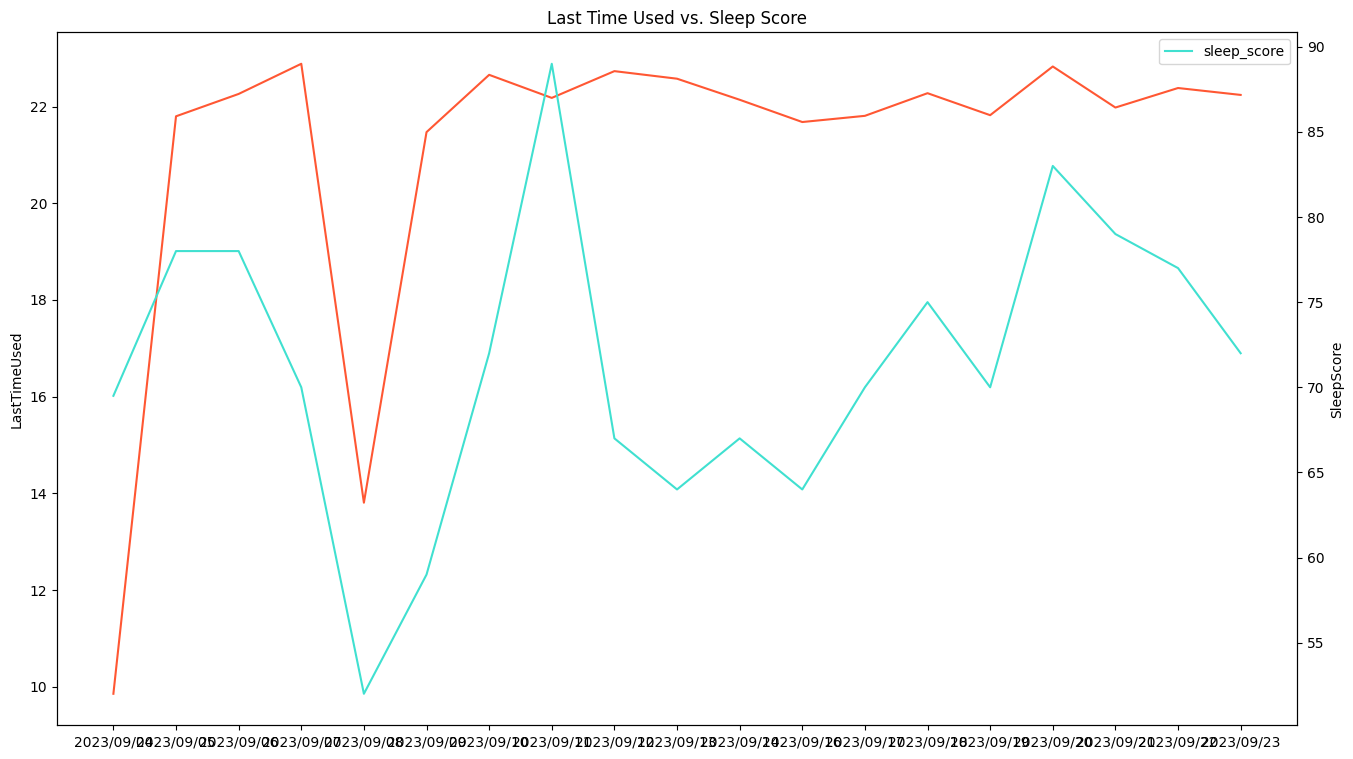

In [135]:
merged = pd.merge(computer_usage, daily_sleep, on="datetime")
print(merged.head(5))
plot_variables(merged, "datetime", ["last_time_used", "sleep_score"], True, "Last Time Used vs. Sleep Score")

# All Data

In [ ]:

# all_daily_data = 